In [1]:
# !unzip -q /content/dataset1.zip
# !unzip -q /content/dataset2.zip
!unzip -q /content/dataset3.zip
# !unzip -q /content/dataset4.zip

# Mục mới

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

image_size = (224, 224)
input_shape_resnet = (image_size[0], image_size[1], 3)
batch_size = 32
data_dir = "/content/dataset3"
validation_split_ratio = 0.2

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
    validation_split=validation_split_ratio
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=validation_split_ratio
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=False
)

num_classes = train_generator.num_classes
print(f"Số lớp (loài chim): {num_classes}")
print(f"Nhãn lớp: {train_generator.class_indices}")

class_labels = list(train_generator.class_indices.keys())

Found 652 images belonging to 6 classes.
Found 159 images belonging to 6 classes.
Số lớp (loài chim): 6
Nhãn lớp: {'AMERICAN GOLDFINCH': 0, 'BARN OWL': 1, 'CARMINE BEE-EATER': 2, 'DOWNY WOODPECKER': 3, 'EMPEROR PENGUIN': 4, 'FLAMINGO': 5}


In [3]:
# Cell 4 - Điều chỉnh
from tensorflow.keras.models import Model,Sequential # Import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, Input # Bỏ BatchNormalization nếu không dùng ở custom head hoặc ResNet50 đã có
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2 # Bỏ nếu không dùng

# Tải ResNet50 tiền huấn luyện
base_model_resnet = ResNet50(weights='imagenet',
                             include_top=False, # Bỏ lớp phân loại cuối cùng
                             input_shape=input_shape_resnet)

# Đóng băng các lớp của base_model
base_model_resnet.trainable = False # Quan trọng: đóng băng base model

model = Sequential([
    base_model_resnet, # Đặt base_model đã đóng băng làm lớp đầu tiên
    GlobalAveragePooling2D(), # Hoặc Flatten()
    # Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])


learning_rate_head = 1e-4
optimizer_head = Adam(learning_rate=learning_rate_head)

model.compile(optimizer=optimizer_head,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,213,766 (100.00 MB)

 Trainable params: 2,626,054 (10.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
# Cell 5 - Điều chỉnh (Giai đoạn 1: Huấn luyện Custom Head)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# # Callbacks tương tự notebook Kaggle
# # Lưu ý tên file checkpoint
# model_checkpoint = ModelCheckpoint(
#     filepath='/content/best_bird_resnet50_model.keras', # Sử dụng .keras hoặc .h5
#     save_best_only=True,
#     monitor='val_accuracy', # Theo dõi val_accuracy
#     mode='max', # Lưu khi val_accuracy lớn nhất
#     verbose=1
# )

early_stopping = EarlyStopping(
    monitor='val_accuracy', # Hoặc 'val_loss'
    patience=5,         # Notebook Kaggle có thể dùng patience khác
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,         # Factor giảm learning rate (Kaggle có thể dùng 0.1 hoặc 0.2)
    patience=3,         # Kaggle có thể dùng patience khác
    min_lr=1e-6,        # Learning rate tối thiểu
    verbose=1
)

epochs = 30 # Số epoch huấn luyện, điều chỉnh dựa trên notebook Kaggle hoặc thử nghiệm

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7002 - loss: 0.9846 - val_accuracy: 1.0000 - val_loss: 0.0557 - learning_rate: 1.0000e-04
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 411ms/step - accuracy: 1.0000 - loss: 0.0272 - val_accuracy: 1.0000 - val_loss: 0.0150 - learning_rate: 1.0000e-04
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.0103 - learning_rate: 1.0000e-04
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 415ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0088 - learning_rate: 1.0000e-04
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 413ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0079 - learning_rate: 1.0000e-04
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 372ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0075 - learning_rate: 1.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of th

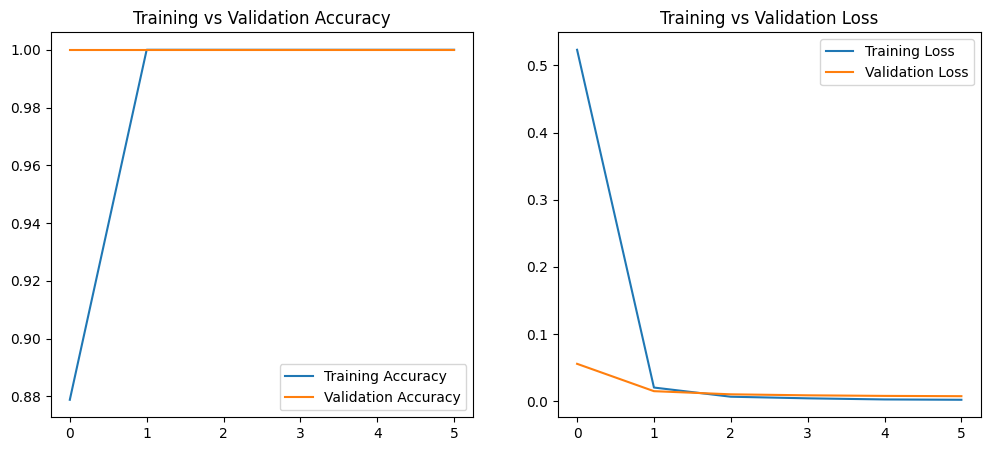

In [5]:
import matplotlib.pyplot as plt # Add this line at

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()


In [6]:
model.save('/content/bird_classifier_model.h5')

In [7]:
loss, accuracy = model.evaluate(val_generator)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 0.0533
Test Loss: 0.0557
Test Accuracy: 1.0000


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 981ms/step


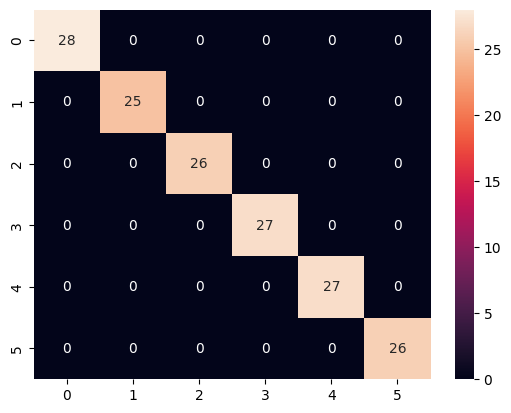

In [8]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score,accuracy_score
import seaborn as sns
import numpy as np

y_true = val_generator.classes
y_pred_prob = model.predict(val_generator)
y_pred = np.argmax(y_pred_prob,axis=1)


cfs_mt = confusion_matrix(y_true, y_pred)

plt.figure()

sns.heatmap(cfs_mt, annot = True, fmt = 'd')

plt.show()

Saving 026.jpg to 026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted: DOWNY WOODPECKER (98.26%)


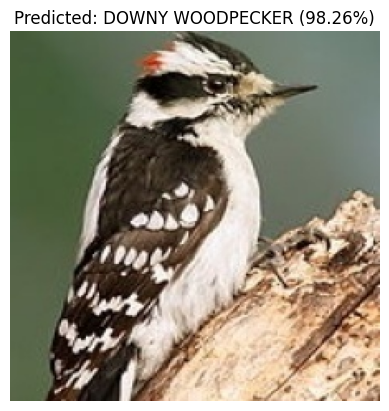

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input


uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=image_size, color_mode='rgb')

    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    img_array_preprocessed = preprocess_input(img_array_expanded.copy())


    prediction = model.predict(img_array_preprocessed)

    class_idx = np.argmax(prediction)
    class_label = list(train_generator.class_indices.keys())[class_idx]
    confidence = prediction[0][class_idx]

    print(f"Predicted: {class_label} ({confidence*100:.2f}%)")

    img_display = Image.open(img_path)
    plt.imshow(img_display)
    plt.title(f"Predicted: {class_label} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()